In [113]:
import spacy
import os
import string
import numpy as np
import nltk
from sklearn.model_selection import train_test_split

# 1. Document reading and cleaning

In [89]:
def read_files(path):
    data = list()
    if os.path.isdir(path):
        for filename in os.listdir(path):
            with open('%s/%s' % (path, filename)) as f:
                doc = f.read()
                doc = doc.replace('<br />','') #replace '<br />' with null
                data.append(doc)
    return data

In [144]:
## IMDB data
neg_data = read_files('/Users/luyin/Downloads/aclImdb/train/neg')
pos_data = read_files('/Users/luyin/Downloads/aclImdb/train/pos')
data = neg_data + pos_data
labels = [0 for _ in range(len(neg_data))] + [1 for _ in range(len(pos_data))]

In [93]:
#split data to train and test
d_train, d_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# 2. Tokenization

In [129]:
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation
digits = string.digits
from spacy.lang.en.stop_words import STOP_WORDS
STOP_WORDS.add("'s")
STOP_WORDS.add(" ")
STOP_WORDS.add(",")# additional stop words for 
# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in dights token.text not in punctuations \
                                                       and token.text not in STOP_WORDS)]

In [109]:
def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens) #append the whole token list as an item
        all_tokens += tokens # combine two list to one list

    return token_dataset, all_tokens

In [111]:
import pickle as pkl

print ("Tokenizing val data...")
val_tokens, _ = tokenize_dataset(d_val)
pkl.dump(val_tokens, open("val_tokens.p", "wb"))


print ("Tokenizing train data...")
train_tokens, all_tokens = tokenize_dataset(d_train)
pkl.dump(train_tokens, open("train_tokens.p", "wb"))
pkl.dump(all_tokens, open("all_tokens.p", "wb"))

Tokenizing val data
Tokenizing train data


In [368]:
print ("Train dataset size is {}".format(len(train_tokens)))
print ("Val dataset size is {}".format(len(val_tokens)))
print ("Total number of tokens in train dataset is {}".format(len(all_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Total number of tokens in train dataset is 2410959


In [635]:
train_tokens = pkl.load(open("/Users/luyin/Downloads/train_tokens.p", "rb"))
all_tokens = pkl.load(open("/Users/luyin/Downloads/all_tokens.p", "rb"))
val_tokens = pkl.load(open("/Users/luyin/Downloads/val_tokens.p", "rb"))

# 3. Creating vocabulary dictionary

In [592]:
from nltk.util import ngrams

n_gram = [1, 2, 3, 4] # ngram return tuple type
unigram = all_tokens
bigrams_vocab = list(ngrams((all_tokens), n_gram[1])) # n_gram = 2
trigrams_vocab = list(ngrams((all_tokens), n_gram[2])) # n_grams = 3
fourgrams_vocab = list(ngrams((all_tokens), n_gram[3])) # n_grams = 4

In [440]:
#tokenize n_gram on training sets and validation sets
bi_train_tokens = []
tri_train_tokens = []
four_train_tokens = []
for sample in train_tokens:
    l2 = list(ngrams((sample), n_gram[1]))
    l3 = list(ngrams((sample), n_gram[2]))
    l4 = list(ngrams((sample), n_gram[3]))
    bi_train_tokens.append(l2)
    tri_train_tokens.append(l3)
    four_train_tokens.append(l4)


In [441]:
bi_val_tokens = []
tri_val_tokens = []
four_val_tokens = []

four_train_tokens = []
for sample in val_tokens:
    l2 = list(ngrams((sample), n_gram[1]))
    l3 = list(ngrams((sample), n_gram[2]))
    l4 = list(ngrams((sample), n_gram[3]))
    bi_val_tokens.append(l2)
    tri_val_tokens.append(l3)
    four_val_tokens.append(l4)


In [593]:
print('The length of all tokens is :{}'.format(len(all_tokens)))
print('Vacabulary of bag of words(ngram = 1) is: {}'.format(len(set(unigram))))
print('Vacabulary of bigrams(ngram = 2) is: {}'.format(len(set(bigrams_vocab))))
print('Vacabulary of trigrams(ngram = 3) is: {}'.format(len(set(trigrams_vocab))))
print('Vacabulary of fourgrams(ngram = 4) is: {}'.format(len(set(fourgrams_vocab))))

The length of all tokens is :2410959
Vacabulary of bag of words(ngram = 1) is: 82955
Vacabulary of bigrams(ngram = 2) is: 1466999
Vacabulary of trigrams(ngram = 3) is: 2244058
Vacabulary of fourgrams(ngram = 4) is: 2378879


In [597]:
fourgrams_vocab[0]

('this', 'good', 'film', 'i')

In [422]:
from collections import Counter

pad_idx = 0
unk_idx = 1

max_vocab_size_list = [10000, 50000, 90000]

def vocabulary_dictionary(token_list, max_vocab_size):
# vocab = set(token_list)
# it is important to find the unique word dictionary
    token_counter = Counter(token_list)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    idx2token = list(vocab)
    # add pad and unk to tokens
    token2idx = dict(zip(vocab, range(2, 2+ len(vocab))))
    idx2token = ['<pad>', '<unk>'] + idx2token
    token2idx['<pad>'] = pad_idx
    token2idx['<unk>'] = unk_idx
    return token2idx , idx2token

In [650]:
#token2id and id2token test
import random
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token: {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token: id {}".format(random_token, token2id[random_token]))

Token id 4420 ; token: disappoint
Token disappoint; token: id 4420


# 4. Convert data into index

In [567]:
def token2index_dataset(tokens_data, token_idx):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token_idx[token] if token in token_idx else unk_idx for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [652]:
#unigram
train_data_indices = token2index_dataset(train_tokens, token2id)
val_data_indices = token2index_dataset(val_tokens, token2id)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))

Train dataset size is 20000
Val dataset size is 5000


In [599]:
# #bigram
# train_data_bi_indices = token2index_dataset(bi_train_tokens, bi_token2id)
# val_data_bi_indices = token2index_dataset(bi_val_tokens, bi_token2id)

# # double checking
# print ("Train dataset size is {}".format(len(train_data_bi_indices)))
# print ("Val dataset size is {}".format(len(val_data_bi_indices)))

# 5. Create Pytorch Dataloader

In [627]:
MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    
    def __init__(self, data_list, target_list):
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    data_list = []
    label_list = []
    length_list = []
    
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]



In [ ]:
# BATCH_SIZE = 32
# train_dataset = NewsGroupDataset(train_data_indices, y_train)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=newsgroup_collate_func,
#                                            shuffle=True)

# val_dataset = NewsGroupDataset(val_data_indices, y_val)
# val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
#                                            batch_size=BATCH_SIZE,
#                                            collate_fn=newsgroup_collate_func,
#                                            shuffle=True)

# 6. N-gram model

In [629]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NgramClassification(nn.Module):
    
    def __init__(self, vocab_size, emb_dim): # at least 100 when you trian your models
        
        super(NgramClassification, self).__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim, 2) # use linear function inside
    
    def forward(self, data, length):
        
        out = self.embed(data.long())
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out


# 7. Model output

In [665]:
BATCH_SIZE = 32
def model_process (ngram_vocab, max_vocab_size, ngram_train_tokens, ngram_val_tokens, ytrain, yval, emb_dim):
    
    #step 1 create dictionary
    token2idx, idx2token = vocabulary_dictionary (ngram_vocab, max_vocab_size)
    #step 2 convert data into index
    train_data_indices = token2index_dataset(ngram_train_tokens, token2idx)
    val_data_indices = token2index_dataset(ngram_val_tokens, token2idx)
    #step 3 create pytorch dataloader
    train_dataset = NewsGroupDataset(train_data_indices, ytrain)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)
    
    val_dataset = NewsGroupDataset(val_data_indices, yval)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)
    model = NgramClassification(len(idx2token), emb_dim)
    
    return train_loader, val_loader, model

In [ ]:
from nltk.util import ngrams

n_gram = [1, 2, 3, 4] # ngram return tuple type
unigram = all_tokens
bigrams_vocab = list(ngrams((all_tokens), n_gram[1])) # n_gram = 2
trigrams_vocab = list(ngrams((all_tokens), n_gram[2])) # n_grams = 3
fourgrams_vocab = list(ngrams((all_tokens), n_gram[3])) # n_grams = 4

In [603]:
#tokenize n_gram on training sets and validation sets
bi_train_tokens = []
tri_train_tokens = []
four_train_tokens = []
for sample in train_tokens:
    l2 = list(ngrams((sample), n_gram[1]))
    l3 = list(ngrams((sample), n_gram[2]))
    l4 = list(ngrams((sample), n_gram[3]))
    bi_train_tokens.append(l2)
    tri_train_tokens.append(l3)
    four_train_tokens.append(l4)

bi_val_tokens = []
tri_val_tokens = []
four_val_tokens = []

for sample in val_tokens:
    l2 = list(ngrams((sample), n_gram[1]))
    l3 = list(ngrams((sample), n_gram[2]))
    l4 = list(ngrams((sample), n_gram[3]))
    bi_val_tokens.append(l2)
    tri_val_tokens.append(l3)
    four_val_tokens.append(l4)

In [630]:
learning_rate = 0.01
num_epochs = 5 # number epoch to train

# # Criterion and Optimizer
# criterion = torch.nn.CrossEntropyLoss()  
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1) #use the softmax to output
        predicted = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
        #https://pytorch.org/docs/0.3.1/torch.html#torch.max
        #Returns the maximum value of each row of the input tensor in the given dimension dim. The second return value is the index location of each maximum value found (argmax).
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [707]:
def model_run (train_data, val_data, model_num, learning_r, num_epc):

# Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model_num.parameters(), lr=learning_r)
    max_acc = []
    for epoch in range(num_epc):
        acc = []
        for i, (data, lengths, labels) in enumerate(train_data):
            model_num.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model_num(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
        # validate every 100 iterations
            
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_data, model_num)
#                 print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
#                        epoch+1, num_epc, i+1, len(train_data), val_acc))
                acc.append(val_acc)
        max_acc += acc
    return max(max_acc)         

In [607]:
# emb_dim = 100
# # model2 = NgramClassification(len(bi_id2token), emb_dim)
# model = NgramClassification(len(id2token), emb_dim)
# model2 = NgramClassification(len(bi_id2token), emb_dim)
# model3 = NgramClassification(len(tri_id2token), emb_dim)
# model4 = NgramClassification(len(four_id2token), emb_dim)

# 8. Hyper-parameter experiment

### 8.1 ngram with 10000 vocabulary size and emb = 100

In [717]:
model_result = {}

In [706]:
#unigram
train_loader1, val_loader1, model_1 = model_process (all_tokens, 10000, train_tokens, val_tokens, y_train, y_val, 100)
acc1 = model_run(train_loader1, val_loader1, model_1, learning_rate , num_epochs)
model_result[1] = acc1
#bigram
train_loader2, val_loader2, model_2 = model_process (bigrams_vocab, 10000, bi_train_tokens, bi_val_tokens, y_train, y_val,100)
acc2 = model_run(train_loader2, val_loader2, model_2, 0.01 , num_epochs)
model_result[2] = acc2
#trigram
train_loader3, val_loader3, model_3 = model_process (trigrams_vocab, 10000, tri_train_tokens, tri_val_tokens, y_train, y_val,100)
acc3 = model_run(train_loader3, val_loader3, model_3, learning_rate , num_epochs)
model_result[3] = acc3
#fourgram
train_loader4, val_loader4, model_4 = model_process (fourgrams_vocab, 10000, four_train_tokens, four_val_tokens, y_train, y_val,100)
acc4 = model_run(train_loader4, val_loader4, model_4, learning_rate , num_epochs)
model_result[4] = acc4

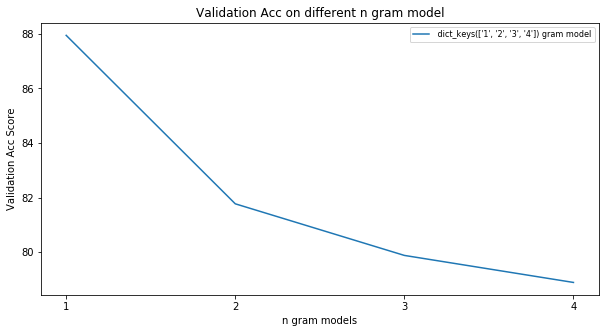

In [705]:
ngram = model_result.keys()
acc_result = model_result.values()
plt.figure(figsize=(10, 5))

plt.plot(ngram, acc_result, label = ' {} gram model'.format(ngram))
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('n gram models')
plt.ylabel('Validation Acc Score')
plt.title("Validation Acc on different n gram model")
plt.show()

In [675]:
# train_loader1, val_loader1, model_1 = model_process (all_tokens, 10000, train_tokens, val_tokens, y_train, y_val, 100)
# train_loader2, val_loader2, model_2 = model_process (bigrams_vocab, 50000, bi_train_tokens, bi_val_tokens, y_train, y_val,100)
# train_loader3, val_loader3, model_3 = model_process (trigrams_vocab, 100000, tri_train_tokens, tri_val_tokens, y_train, y_val,100)
# train_loader4, val_loader4, model_4 = model_process (fourgrams_vocab, 150000, four_train_tokens, four_val_tokens, y_train, y_val,100)

In [676]:
# model_run(train_loader1, val_loader1, model_1, learning_rate , num_epochs)
# model_run(train_loader2, val_loader2, model_2, learning_rate , num_epochs)
# model_run(train_loader3, val_loader3, model_3, learning_rate , num_epochs)
# model_run(train_loader4, val_loader4, model_4, learning_rate , num_epochs)

### 8.2 n gram for different Vocabulary size

In [708]:
model_result_2 = {}

max_vocab_size_list = [10000, 50000, 90000]
for max_vocab in max_vocab_size_list:
    train_loader1, val_loader1, model_1 = model_process (all_tokens, max_vocab, train_tokens, val_tokens, y_train, y_val, 100)
    acc = model_run(train_loader1, val_loader1, model_1, learning_rate , num_epochs)
    model_result_2[str(max_vocab)] = acc

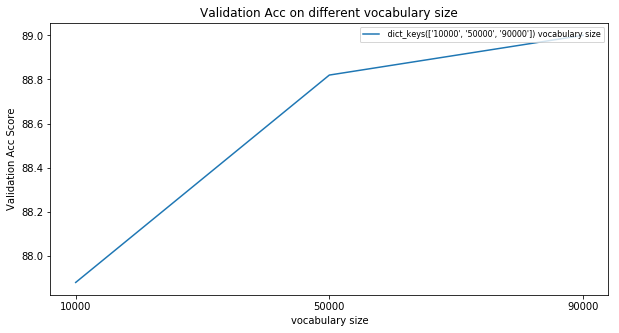

In [716]:
vocab_size = model_result_2.keys()
acc_result = model_result_2.values()
plt.figure(figsize=(10, 5))

plt.plot(vocab_size, acc_result, label = ' {} vocabulary size'.format(vocab_size))
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('vocabulary size')
plt.ylabel('Validation Acc Score')
plt.title("Validation Acc on different vocabulary size")
plt.show()

### 8.3 Different Embedding size

In [722]:
embd_size = [100,120, 150, 500]
model_result_3 = {}

In [725]:
for embd_dims in max_vocab_size_list:
    train_loader1, val_loader1, model_1 = model_process (all_tokens, 10000, train_tokens, val_tokens, y_train, y_val, embd_dims)
    acc = model_run(train_loader1, val_loader1, model_1, learning_rate , num_epochs)
    model_result_3[str(embd_dims)] = acc

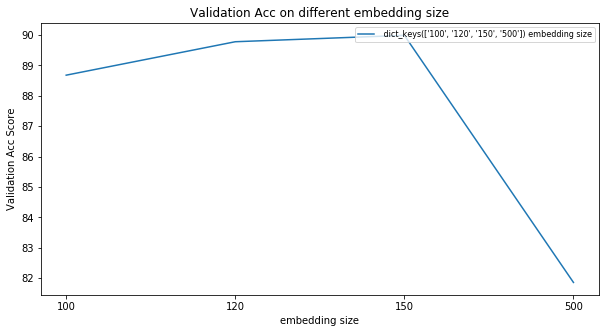

In [730]:
embd_size = model_result_3.keys()
acc_result = model_result_3.values()
plt.figure(figsize=(10, 5))

plt.plot(embd_size, acc_result, label = ' {} embedding size'.format(embd_size))
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('embedding size')
plt.ylabel('Validation Acc Score')
plt.title("Validation Acc on different embedding size")
plt.show()

### 8.4 Comparing Optimization hyperparameters

In [731]:
#USE SGD optimizer

def model_run_SGD (train_data, val_data, model_num, learning_r, num_epc):

# Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.SGD(model_num.parameters(), lr=learning_r)
    max_acc = []
    for epoch in range(num_epc):
        acc = []
        for i, (data, lengths, labels) in enumerate(train_data):
            model_num.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model_num(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
        # validate every 100 iterations
            
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_data, model_num)
#                 print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
#                        epoch+1, num_epc, i+1, len(train_data), val_acc))
                acc.append(val_acc)
        max_acc += acc
    return max(max_acc) 

In [732]:
train_loader1, val_loader1, model_1 = model_process (all_tokens, 10000, train_tokens, val_tokens, y_train, y_val, 100)
acc_Ada = model_run(train_loader1, val_loader1, model_1, learning_rate , num_epochs)
acc_sgd = model_run_SGD(train_loader1, val_loader1, model_1, learning_rate , num_epochs)

In [735]:
print("The maximum validation acc of Adam optimization is : {}".format(acc_Ada))
print("The maximum validation acc of SGD optimization is : {}".format(acc_sgd))

The maximum validation acc of Adam optimization is : 87.7
The maximum validation acc of SGD optimization is : 85.92


In [772]:
def model_output(loader, model):
    
    correct = 0
    total = 0
    l = []
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1) #use the softmax to output
        predicted = outputs.max(1, keepdim=True)[1]
        l += list(predicted.eq(labels.view_as(predicted)))
    return l

In [773]:
l = model_output(val_loader1, model_1)

In [775]:
# print(l)